In [1]:
from subprocess import check_output
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm

import torch.backends.cudnn as cudnn
import random

## Claim: the data preprocessing part is from https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide/notebook

In [2]:
# This code is from https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy

class Data(Dataset):
    
    def __init__(self, data, transform = None):
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [3]:
train_csv = pd.read_csv("fashion-mnist_train.csv")
test_csv = pd.read_csv("fashion-mnist_test.csv")

train_data = Data(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_data = Data(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

batch_size = 256
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [4]:
# From now on, we start to build our model
# We are also really big sad that we can't use maxpool inside sequential

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # image shape is 28 * 28 * 1, where 1 is one color channel
        # 28 * 28 is the image size
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        # output shape = (28 - 3 + 1) * (28 - 3 + 1) * 3 = 26 * 26 * 32
        # maxpooling
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # output shape = 13 * 13 * 32
        # Note the volumn depth is not changed

        #self.dropout = nn.Dropout(p=0.25)
        # output shape = 13 * 13 * 32


        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        # output shape = (13 - 3 + 1) * (13 - 3 + 1) * 64 = 11 * 11 * 64

        # maxpooling
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # output shape = 5 * 5 * 64

        #self.dropout = nn.Dropout(p=0.25)


        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        # output shape = (5 - 3 + 1) * (5 - 3 + 1) * 128 = 3 * 3 * 128

        self.dropout = nn.Dropout(p=0.4)
        # output shape = 3 * 3 * 128
        
        # fully connected layer
        self.fc1 = nn.Linear(3*3*128, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        # first conv
        x = self.pool1(F.relu(self.conv1(x)))
        #x = self.dropout(x)
        x = self.pool2(F.relu(self.conv2(x)))
        #x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)

        # fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x))
        return x

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [6]:
model.train()
epoches = 40
lost = []
for epoch in tqdm(range(epoches)):
    train_loss, correct = 0, 0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        
        pred = model(X)

        loss = loss_fn(pred, y.long())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record loss
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    size = len(train_dataloader.dataset)
    train_loss /= len(train_dataloader)
    correct /= size
    print(f" Train accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f}")
    lost.append(train_loss)


  2%|▎         | 1/40 [00:19<12:42, 19.54s/it]

 Train accuracy: 48.2%, Avg loss: 1.977367


  5%|▌         | 2/40 [00:38<12:05, 19.10s/it]

 Train accuracy: 66.8%, Avg loss: 1.793940


  8%|▊         | 3/40 [00:57<11:42, 19.00s/it]

 Train accuracy: 71.9%, Avg loss: 1.743260


 10%|█         | 4/40 [01:15<11:20, 18.91s/it]

 Train accuracy: 73.8%, Avg loss: 1.724006


 12%|█▎        | 5/40 [01:34<10:59, 18.85s/it]

 Train accuracy: 74.9%, Avg loss: 1.712741


 15%|█▌        | 6/40 [01:53<10:39, 18.81s/it]

 Train accuracy: 75.7%, Avg loss: 1.703312


 18%|█▊        | 7/40 [02:12<10:24, 18.93s/it]

 Train accuracy: 76.5%, Avg loss: 1.696177


 20%|██        | 8/40 [02:31<10:03, 18.87s/it]

 Train accuracy: 76.9%, Avg loss: 1.692055


 22%|██▎       | 9/40 [02:50<09:46, 18.92s/it]

 Train accuracy: 77.2%, Avg loss: 1.688604


 25%|██▌       | 10/40 [03:09<09:27, 18.93s/it]

 Train accuracy: 77.7%, Avg loss: 1.684423


 28%|██▊       | 11/40 [03:28<09:08, 18.91s/it]

 Train accuracy: 78.1%, Avg loss: 1.680595


 30%|███       | 12/40 [03:46<08:47, 18.84s/it]

 Train accuracy: 84.8%, Avg loss: 1.614080


 32%|███▎      | 13/40 [04:05<08:26, 18.75s/it]

 Train accuracy: 86.3%, Avg loss: 1.598788


 35%|███▌      | 14/40 [04:24<08:07, 18.74s/it]

 Train accuracy: 86.9%, Avg loss: 1.592408


 38%|███▊      | 15/40 [04:43<07:49, 18.78s/it]

 Train accuracy: 87.4%, Avg loss: 1.587887


 40%|████      | 16/40 [05:01<07:30, 18.76s/it]

 Train accuracy: 87.6%, Avg loss: 1.585110


 42%|████▎     | 17/40 [05:20<07:12, 18.79s/it]

 Train accuracy: 87.8%, Avg loss: 1.583822


 45%|████▌     | 18/40 [05:39<06:53, 18.78s/it]

 Train accuracy: 88.1%, Avg loss: 1.580709


 48%|████▊     | 19/40 [05:58<06:33, 18.75s/it]

 Train accuracy: 88.3%, Avg loss: 1.578683


 50%|█████     | 20/40 [06:16<06:16, 18.80s/it]

 Train accuracy: 88.5%, Avg loss: 1.576797


 52%|█████▎    | 21/40 [06:36<05:59, 18.90s/it]

 Train accuracy: 88.5%, Avg loss: 1.576272


 55%|█████▌    | 22/40 [06:55<05:42, 19.01s/it]

 Train accuracy: 88.8%, Avg loss: 1.573571


 57%|█████▊    | 23/40 [07:14<05:22, 18.97s/it]

 Train accuracy: 88.8%, Avg loss: 1.573357


 60%|██████    | 24/40 [07:33<05:03, 18.96s/it]

 Train accuracy: 89.1%, Avg loss: 1.570795


 62%|██████▎   | 25/40 [07:51<04:43, 18.91s/it]

 Train accuracy: 89.2%, Avg loss: 1.569685


 65%|██████▌   | 26/40 [08:11<04:25, 18.98s/it]

 Train accuracy: 89.2%, Avg loss: 1.569424


 68%|██████▊   | 27/40 [08:30<04:08, 19.10s/it]

 Train accuracy: 89.4%, Avg loss: 1.567250


 70%|███████   | 28/40 [08:49<03:47, 19.00s/it]

 Train accuracy: 89.6%, Avg loss: 1.565871


 72%|███████▎  | 29/40 [09:08<03:28, 18.95s/it]

 Train accuracy: 89.6%, Avg loss: 1.564958


 75%|███████▌  | 30/40 [09:26<03:08, 18.89s/it]

 Train accuracy: 89.7%, Avg loss: 1.564024


 78%|███████▊  | 31/40 [09:45<02:49, 18.88s/it]

 Train accuracy: 89.9%, Avg loss: 1.562507


 80%|████████  | 32/40 [10:04<02:30, 18.85s/it]

 Train accuracy: 89.9%, Avg loss: 1.562655


 82%|████████▎ | 33/40 [10:24<02:13, 19.08s/it]

 Train accuracy: 90.1%, Avg loss: 1.560568


 85%|████████▌ | 34/40 [10:43<01:54, 19.04s/it]

 Train accuracy: 90.2%, Avg loss: 1.559520


 88%|████████▊ | 35/40 [11:01<01:34, 18.98s/it]

 Train accuracy: 90.2%, Avg loss: 1.559374


 90%|█████████ | 36/40 [11:20<01:15, 18.93s/it]

 Train accuracy: 90.4%, Avg loss: 1.557679


 92%|█████████▎| 37/40 [11:39<00:56, 18.89s/it]

 Train accuracy: 90.4%, Avg loss: 1.557501


 95%|█████████▌| 38/40 [11:58<00:37, 18.85s/it]

 Train accuracy: 90.5%, Avg loss: 1.556698


 98%|█████████▊| 39/40 [12:17<00:18, 18.94s/it]

 Train accuracy: 90.5%, Avg loss: 1.556369


100%|██████████| 40/40 [12:36<00:00, 18.91s/it]

 Train accuracy: 90.7%, Avg loss: 1.554640


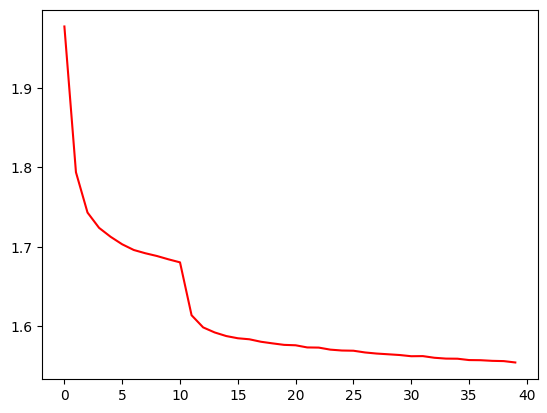

In [8]:
plt.plot(np.array(lost), 'r')

In [7]:
# testing set

model.eval()
correct = 0
# Turn off gradient descent
with torch.no_grad():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
size = len(test_dataloader.dataset)
correct = correct / size
print(f" Test accuracy: {(100*correct):>0.1f}%")

100%|██████████| 40/40 [00:00<00:00, 46.56it/s]

 Test accuracy: 90.5%
